## 1. Install the depencies

In [1]:
!pip install -U openmim
!mim install mmengine
!mim install "mmcv>=2.0.0"
!mim install mmdet==3.0.0rc4

Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html


In [2]:
!pip install "mmsegmentation>=1.0.0"

In [3]:
!apt-get install imagemagick imagemagick-doc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
imagemagick is already the newest version (8:6.9.11.60+dfsg-1.3ubuntu0.22.04.3).
imagemagick-doc is already the newest version (8:6.9.11.60+dfsg-1.3ubuntu0.22.04.3).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [4]:
import os
import cv2
import math
import time
import subprocess
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import progressbar

import mmcv
from mmseg.apis import inference_model, init_model, show_result_pyplot

In [5]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [6]:
from google.colab import drive
drive.mount('/gdrive')
drive_root = '/gdrive/MyDrive/mmseg/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## 2. Define the paths
##### Just change the path according to you system

In [7]:
GT_DIR = drive_root + 'data/cityscapes/gtFine/'
IMG_DIR = drive_root + 'data/cityscapes/leftImg8bit/'
config_file = drive_root + 'configs/config.py'
checkpoint_file = drive_root + 'configs/checkpoints.pth'

## 3. Helper functions

In [8]:
# Define the widgets for the progress bar
def show_process_bar(topic):
    widgets = ['[', progressbar.Timer(format= f'{topic}: %(elapsed)s'), '] ',
        progressbar.Bar('*'),' (', progressbar.ETA(), ') ']

    # Create a progress bar with a maximum value of 100 and the defined widgets
    bar = progressbar.ProgressBar(max_value=100,widgets=widgets)
    return bar

In [9]:
# Converts PNG images to JPG format in the specified folder and its subfolders.
def convert_png_to_jpg(root_folder, quality=100):
    for root, _, _ in os.walk(root_folder):
        # Use the mogrify command to convert PNG to JPG
        logging.info(f'Converting the images from png to img ({root})')
        subprocess.run('mogrify -format jpg -set filename:name %t -write %[filename:name]_100.jpg *.png', cwd=root, shell=True)

In [10]:
# Reduces the quality of JPEG images in the specified folder and its subfolders.
def reduce_quality(root_folder, quality):
    for root, _, _ in os.walk(root_folder):
        # Use the mogrify command to reduce the quality of JPEG images
        logging.info(f'Converting the images from png to img ({root})')
        subprocess.run(f'mogrify -quality {quality} -set filename:name %t -write %[filename:name]_{quality}.jpg *_100.jpg', cwd=root, shell=True)

In [11]:
# Recursively retrieves paths to image files in the specified directory and its subdirectories.
def get_image_paths(root_dir, ends_with):
    image_paths = []
    for item in os.listdir(root_dir):
        item_path = os.path.join(root_dir, item)
        if os.path.isdir(item_path):
            image_paths.extend(get_image_paths(item_path, ends_with))
        elif item.lower().endswith(ends_with):
            image_paths.append(item_path)
    return sorted(image_paths)

In [12]:
# Calculate IoU from predicted image and true mask
def calculate_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask)
    union = np.logical_or(pred_mask, true_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [13]:
# Save the predicted images to specific folder
def save_images(folder_name, imgs, val_gt_images):
    for i, img in enumerate(imgs):
        image_path = val_gt_images[i].replace('gtFine/', folder_name)
        image = Image.fromarray(img)

        directory = os.path.dirname(image_path)
        os.makedirs(directory, exist_ok=True)

        # Save the image as a PNG file (or any other supported format)
        # print(image_path)
        image.save(image_path)

In [14]:
def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)  # Convert to float32
    img /= 255.0
    return img

## 3. Pre-processing of the images

In [15]:
# Convert the images from png to jpg
convert_png_to_jpg(IMG_DIR+'val/')

INFO:root:Converting the images from png to img (/gdrive/MyDrive/mmseg/data/cityscapes/leftImg8bit/val/)
INFO:root:Converting the images from png to img (/gdrive/MyDrive/mmseg/data/cityscapes/leftImg8bit/val/frankfurt)
INFO:root:Converting the images from png to img (/gdrive/MyDrive/mmseg/data/cityscapes/leftImg8bit/val/munster)
INFO:root:Converting the images from png to img (/gdrive/MyDrive/mmseg/data/cityscapes/leftImg8bit/val/lindau)


In [16]:
# Reduce the quality of images to 75% and 25%
reduce_quality(IMG_DIR+'val/', quality=75)
reduce_quality(IMG_DIR+'val/', quality=25)

INFO:root:Converting the images from png to img (/gdrive/MyDrive/mmseg/data/cityscapes/leftImg8bit/val/)
INFO:root:Converting the images from png to img (/gdrive/MyDrive/mmseg/data/cityscapes/leftImg8bit/val/frankfurt)
INFO:root:Converting the images from png to img (/gdrive/MyDrive/mmseg/data/cityscapes/leftImg8bit/val/munster)
INFO:root:Converting the images from png to img (/gdrive/MyDrive/mmseg/data/cityscapes/leftImg8bit/val/lindau)
INFO:root:Converting the images from png to img (/gdrive/MyDrive/mmseg/data/cityscapes/leftImg8bit/val/)
INFO:root:Converting the images from png to img (/gdrive/MyDrive/mmseg/data/cityscapes/leftImg8bit/val/frankfurt)
INFO:root:Converting the images from png to img (/gdrive/MyDrive/mmseg/data/cityscapes/leftImg8bit/val/munster)
INFO:root:Converting the images from png to img (/gdrive/MyDrive/mmseg/data/cityscapes/leftImg8bit/val/lindau)


In [17]:
# get all the path of validation images
val_gt_images = get_image_paths(GT_DIR + 'val/', '_gtFine_color.png'.lower())

In [18]:
# get path of all the images
val_images_100 = get_image_paths(IMG_DIR + 'val/', '_100.jpg'.lower())
val_images_75 = get_image_paths(IMG_DIR + 'val/', '_75.jpg'.lower())
val_images_25 = get_image_paths(IMG_DIR + 'val/', '_25.jpg'.lower())

## 4. Model Loading, Training & Evaluation

In [20]:
def predict(model, imgs, folder_name):
    # Create a progress bar for tracking image processing progress
    process_bar = show_process_bar('Processed Images').start()

    # Initialize lists to store IoU values and predicted images
    IoUs = []
    pred_images = []

    # Calculate the total number of images to process
    total_images = len(imgs)

    # Initialize a variable to keep track of processed images
    image_processed = 0

    # Iterate through pairs of input images and ground truth images
    for index, (img, val_img) in enumerate(zip(imgs, val_gt_images)):
        # Update the progress bar
        process_bar.update(math.floor(index * 100 / total_images))

        # Perform inference using the model
        result = inference_model(model, img)

        # Generate a predicted mask from the inference result
        pred_mask = show_result_pyplot(model, imgs[0], result, opacity=1)
        true_mask = np.array(Image.open(val_img))[:, :, :-1]

        # Calculate Intersection over Union (IoU) and store it
        IoUs.append(calculate_iou(pred_mask, true_mask))

        # Append the predicted mask to the list
        pred_images.append(pred_mask)

        # Save predicted images in chunks of 50
        if len(pred_images) % 50 == 0:
            save_images(folder_name, pred_images, val_gt_images[image_processed: image_processed + 50])
            image_processed += 50
            pred_images = []

    # Save any remaining images
    if len(pred_images) > 0:
        save_images(folder_name, pred_images, val_gt_images[image_processed:])

    # Return the IoU values
    return IoUs


In [21]:
# build the model from a config file and a checkpoint file
model = init_model(config_file, checkpoint_file, device='cuda:0')

/usr/local/lib/python3.10/dist-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/usr/local/lib/python3.10/dist-packages/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /gdrive/MyDrive/mmseg/configs/checkpoints.pth


In [22]:
logging.info('Processing stared for validation images with 100% quality...')
IoU_100 = predict(model, val_images_100, 'gtFine_100/')
mIoU_100 = sum(IoU_100)/len(val_images_100)
logging.info(f'mIoU for 100% quality images is : {mIoU_100}')

INFO:root:Processing stared for validation images with 100% quality...
[Processed Images: 0:00:00] |                               | (ETA:  --:--:--) /usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '
[Processed Images: 0:15:11] |****************************** | (ETA:   0:00:09) INFO:root:mIoU for 100% quality images is : 0.8872493960083153


In [23]:
logging.info('Processing stared for validation images with 75% quality...')
IoU_75 = predict(model, val_images_75, 'gtFine_75')
mIoU_75 = sum(IoU_75)/len(val_images_75)
logging.info(f'mIoU for 75% quality images is : {mIoU_75}')

INFO:root:Processing stared for validation images with 75% quality...
[Processed Images: 0:11:37] |****************************** | (ETA:   0:00:07) INFO:root:mIoU for 75% quality images is : 0.8865797383021564


In [24]:
logging.info('Processing stared for validation images with 25% quality...')
IoU_25 = predict(model, val_images_25, 'gtFine_25')
mIoU_25 = sum(IoU_25)/len(val_images_25)
logging.info(f'mIoU for 25% quality images is : {mIoU_25}')


INFO:root:Processing stared for validation images with 25% quality...
[Processed Images: 0:11:35] |****************************** | (ETA:   0:00:07) INFO:root:mIoU for 25% quality images is : 0.8702458304208128


## 5. Plot the graphs from mIoU

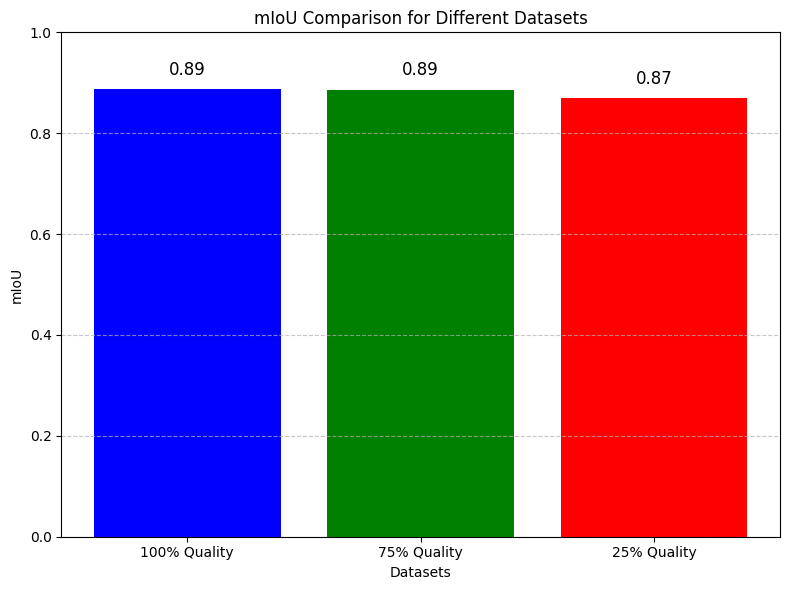

In [25]:
import matplotlib.pyplot as plt

# Define the dataset names and their corresponding mIoU values
datasets = ['100% Quality', '75% Quality', '25% Quality']
miou_values = [mIoU_100, mIoU_75, mIoU_25]  # Replace with your actual mIoU values

# Create a bar plot for mIoU values
plt.figure(figsize=(8, 6))
plt.bar(datasets, miou_values, color=['blue', 'green', 'red'])
plt.xlabel('Datasets')
plt.ylabel('mIoU')
plt.title('mIoU Comparison for Different Datasets')
plt.ylim(0, 1.0)  # Set the y-axis limits between 0 and 1 (since mIoU ranges from 0 to 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display mIoU values above the bars
for i, miou in enumerate(miou_values):
    plt.text(i, miou + 0.02, f'{miou:.2f}', ha='center', va='bottom', fontsize=12, color='black')

# Show the plot
plt.tight_layout()
plt.show()

## Bonus Task

In [26]:
# train data
im_train_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'train/', '_100.jpg'))
im_train_ds = im_train_ds.map(load_and_preprocess_image)

# Validation data
im_val_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'val/', '_100.jpg'))
im_val_ds = im_val_ds.map(load_and_preprocess_image)

# test data
im_test_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'test/', '_100.jpg'))
im_test_ds = im_test_ds.map(load_and_preprocess_image)

In [27]:
# load model from checkpoints
from mmseg.apis import init_model

# Initialize the segmentor
model = init_model(config_file, checkpoint_file, device='cuda:0')  # Use 'cpu' if you want to load the model on the CPU

Loads checkpoint by local backend from path: /gdrive/MyDrive/mmseg/configs/checkpoints.pth


In [29]:
!python {drive_root}/tools/train.py {drive_root}/configs/config.py

09/07 20:08:45 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
    CUDA available: True
    numpy_random_seed: 1409389196
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_5